[![image](https://raw.githubusercontent.com/visual-layer/visuallayer/main/imgs/vl_horizontal_logo.png)](https://www.visual-layer.com)

# Investigating BLIP model performance with fastdup

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/visual-layer/fastdup/blob/main/examples/blip_laion_captions.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/visual-layer/fastdup/blob/main/examples/blip_laion_captions.ipynb)

This notebook shows how you can use [fastdup](https://github.com/visual-layer/fastdup) to analyze model captions generated with BLIP.

## Generate Labels With BLIP

First, we will initiate the BLIP model using the transformers library.

In [28]:
from tqdm import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import cv2
import numpy as np    
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
 
def generate_blip_labels(filenames, kwargs):
    #print('got files', filenames)
    try:
       
        preds = []
        images = []
        for image_path in filenames:
            i_image = Image.open(image_path)
            if i_image is not None:
                i_image = cv2.cvtColor(np.array(i_image), cv2.COLOR_BGR2RGB)
                im_pil = Image.fromarray(i_image)
                images.append(im_pil)
            else:
                print('Non image' + image_path)
                
        inputs = processor(images, return_tensors="pt")
        out = model.generate(**inputs)
        for i in range(len(out)):
            preds.append((processor.decode(out[i], skip_special_tokens=True)))
        return preds
    except Exception as e:
        print(e)
        #fastdup_capture_exception("Auto caption image blip", e)
        return None


Next, we will load in a LAION image dataset and generate captions for the images.

In [29]:
files=!find laion_10K/ -name '*.jpg'

In [30]:
from tqdm import tqdm
images = []
out = []
for i in tqdm(range(len(files)//10)):
    curfiles = files[i*10:i*10+10]
    curout = generate_blip_labels(curfiles, {})
    images.extend(curfiles)
    out.extend(curout)
import pandas as pd
import fastdup
df = pd.DataFrame({'from':images, 'to':images, 'label':out})
df.to_csv('all_labels')


100%|██████████████████████████████████████████████████████████████████| 1000/1000 [2:57:09<00:00, 10.63s/it]


In [36]:
df.head()

,from,to,label
0,laion_10K//001025133.jpg,laion_10K//001025133.jpg,a close up of a coat on a mannequin dummy
1,laion_10K//000843093.jpg,laion_10K//000843093.jpg,a close up of a dress on a mannequin mannequin
2,laion_10K//000157698.jpg,laion_10K//000157698.jpg,a close up of a soccer game with a large crowd watching
3,laion_10K//000927273.jpg,laion_10K//000927273.jpg,"asthma and allergies laura b both extension associate, environmental health education alabama cooperative extension system auburn"
4,laion_10K//000499672.jpg,laion_10K//000499672.jpg,a close up of a dress on a mannequin mannequin mannequin manne


## Install fastdup

Next, install fastdup and verify the installation.

In [ ]:
import sys
if "google.colab" in sys.modules:
    # Running in Google Colab
    !pip install --force-reinstall --no-cache-dir numpy==1.26.4 scipy fastdup
else:
    # Running outside Colab
    !pip install -Uq fastdup


Now, test the installation. If there's no error message, we are ready to go.

In [1]:
import fastdup
fastdup.__version__

'1.37'

# Run fastdup to cluster images

To run fastdup, simply point `input_dir` to the folder containing images from the dataset. 

In [40]:
fd = fastdup.create(input_dir='laion_10k', work_dir='laion_10k_out')
fd.run(overwrite=True)


FastDup Software, (C) copyright 2022 Dr. Amir Alush and Dr. Danny Bickson.
2023-04-14 16:50:21 [INFO] Going to loop over dir laion_10k
2023-04-14 16:50:21 [INFO] Found total 10000 images to run on, 10000 train, 0 test, name list 10000, counter 10000 
2023-04-14 16:50:33 [INFO] Found total 10000 images to run on
2023-04-14 16:50:35 [INFO] 1597) Finished write_index() NN model
2023-04-14 16:50:35 [INFO] Stored nn model index file laion_10k_out/nnf.index
2023-04-14 16:50:35 [INFO] Total time took 14468 ms
2023-04-14 16:50:35 [INFO] Found a total of 45 fully identical images (d>0.990), which are 0.15 %
2023-04-14 16:50:35 [INFO] Found a total of 2 nearly identical images(d>0.980), which are 0.01 %
2023-04-14 16:50:35 [INFO] Found a total of 525 above threshold images (d>0.900), which are 1.75 %
2023-04-14 16:50:35 [INFO] Found a total of 1000 outlier images         (d<0.050), which are 3.33 %
2023-04-14 16:50:35 [INFO] Min distance found 0.468 max distance 1.000
2023-04-14 16:50:35 [INFO] 

In [47]:
comps = fastdup.find_top_components('laion_10k_out')


In [52]:
df['from'] = df['from'].apply(lambda x: x.replace('//', '/'))
df.head()

,from,to,label
0,laion_10K/001025133.jpg,laion_10K//001025133.jpg,a close up of a coat on a mannequin dummy
1,laion_10K/000843093.jpg,laion_10K//000843093.jpg,a close up of a dress on a mannequin mannequin
2,laion_10K/000157698.jpg,laion_10K//000157698.jpg,a close up of a soccer game with a large crowd watching
3,laion_10K/000927273.jpg,laion_10K//000927273.jpg,"asthma and allergies laura b both extension associate, environmental health education alabama cooperative extension system auburn"
4,laion_10K/000499672.jpg,laion_10K//000499672.jpg,a close up of a dress on a mannequin mannequin mannequin manne


In [54]:
label_dict =  pd.Series(df.label.values,index=df2['from']).to_dict()

In [65]:
comps['label'] = comps['files'].apply(lambda x: [label_dict.get(y.replace('laion_10k', 'laion_10K'),'N/A') for y in x])

In [66]:
comps.head()

,component_id,files,files_ids,distance,len,label
1364,1364,"[laion_10k/000150342.jpg, laion_10k/000295438.jpg, laion_10k/000917354.jpg, laion_10k/001109068.jpg, laion_10k/001120690.jpg]","[1364, 2672, 8082, 9813, 9922]",0.9607,5,"[a resume template for a medical assistant, a resume template for a job in a computer engineering department, a resume template for a job in a computer science department, a document with a black and white image of a man in a suit, a resume template for a job in a computer science department]"
1608,1608,"[laion_10k/000174292.jpg, laion_10k/000177292.jpg, laion_10k/000251959.jpg, laion_10k/000685365.jpg, laion_10k/000713476.jpg]","[1608, 1630, 2314, 6096, 6343]",0.9601,5,"[a white paper with a black and red text that says result of cash flow, a slide from a presentation on the effects of the production of a product, a white screen with a red and black text that says advantages and limitationss of ctr, a white paper with a black and white image of a cell phone, a white paper with a black and white image of a man in a hat]"
401,401,"[laion_10k/000043483.jpg, laion_10k/000713727.jpg, laion_10k/000866598.jpg]","[401, 6346, 7684]",0.9623,3,"[a black t - shirt with the letter n in the center, a black polo shirt with a blue and white design on the chest, a black t - shirt with the words quarannted with somebody soon on it]"
659,659,"[laion_10k/000072839.jpg, laion_10k/000418741.jpg, laion_10k/000693449.jpg]","[659, 3740, 6169]",1.0000,3,"[a white and blue wall hanging with a clock on it, a white and blue wall hanging with a clock on it, a white and blue wall hanging with a clock on it]"
887,887,"[laion_10k/000098275.jpg, laion_10k/000338557.jpg, laion_10k/000886819.jpg]","[887, 3056, 7826]",0.9660,3,"[wittg - who is this guy?, ncdc - national climate data center, qfe - quarterly ceo forecast]"


100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 297.36it/s]


Finished OK. Components are stored as image files laion_10k_out/galleries/components_[index].jpg
Stored components visual view in  laion_10k_out/galleries/components.html
Execution time in seconds 0.1



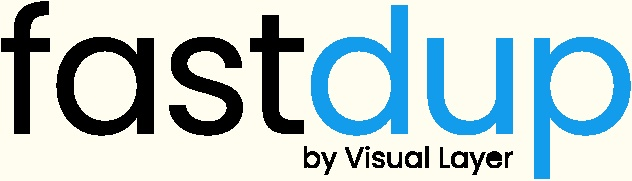
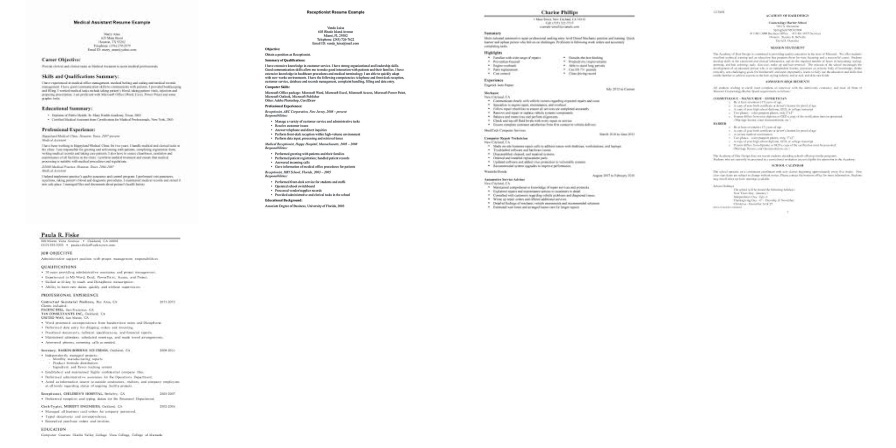
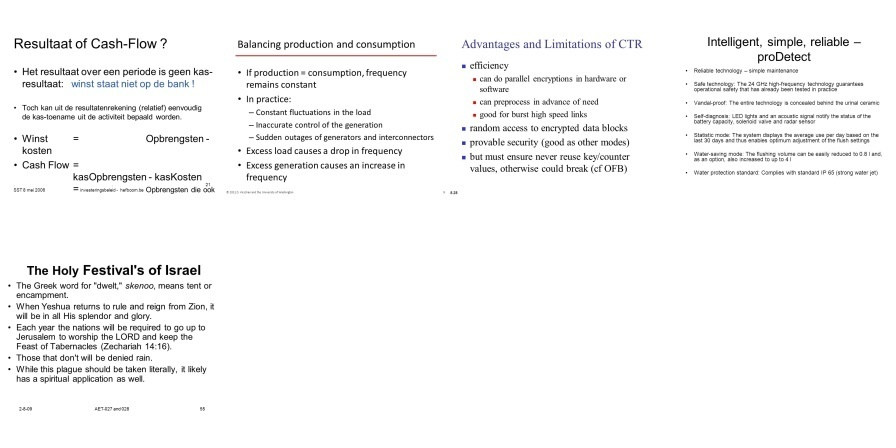
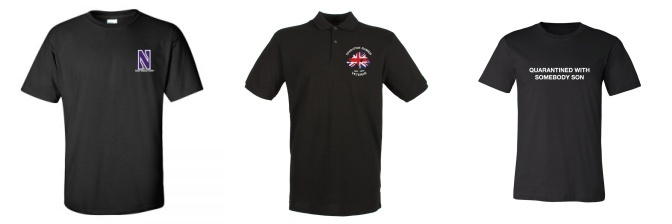
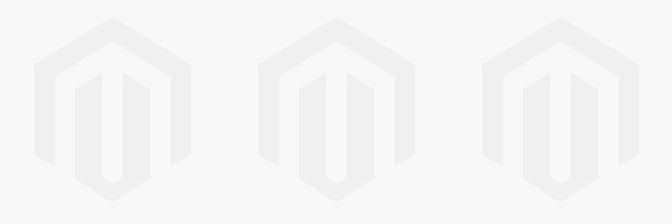
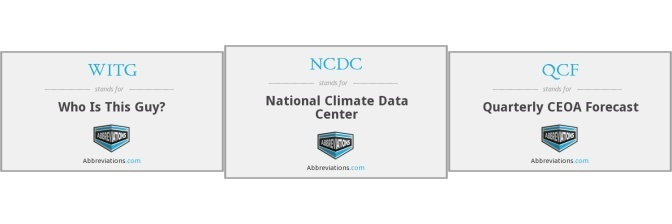
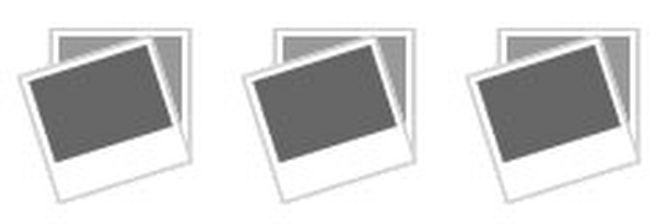
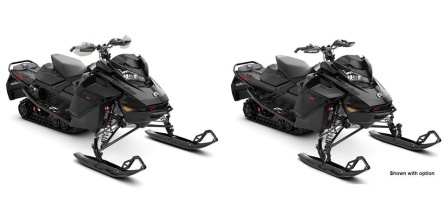
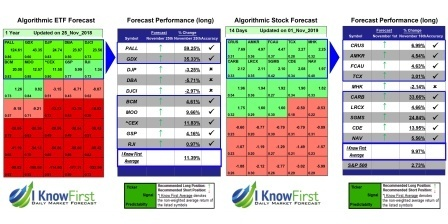
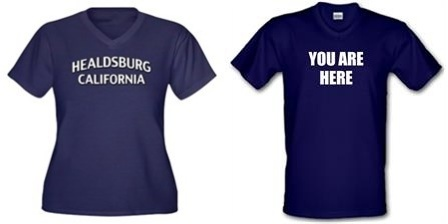
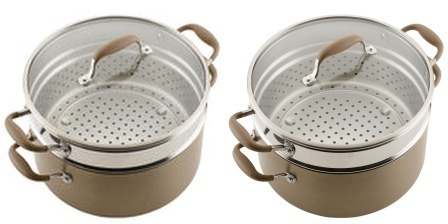
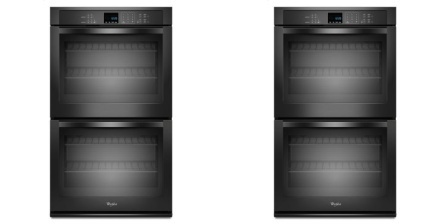
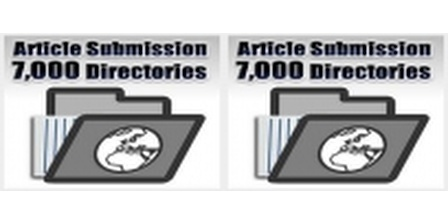
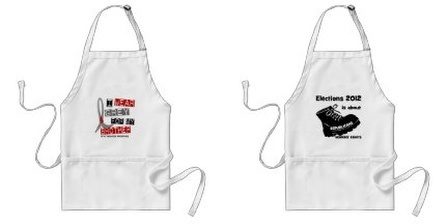
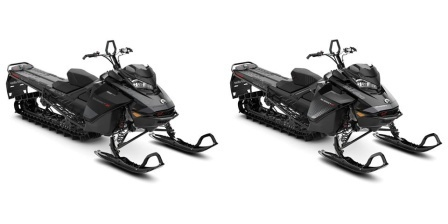
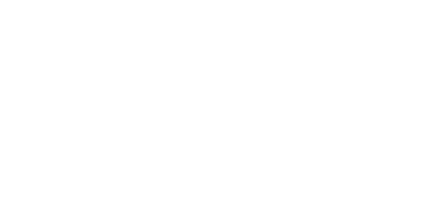
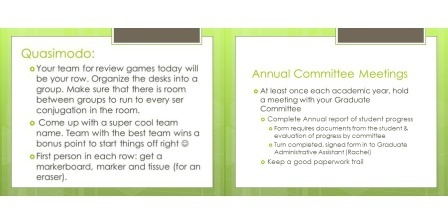
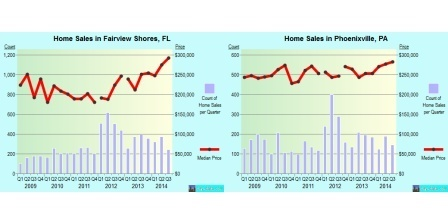
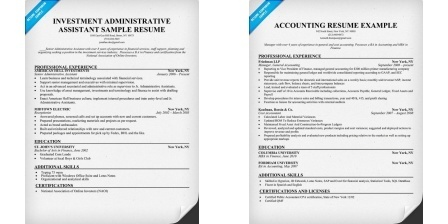
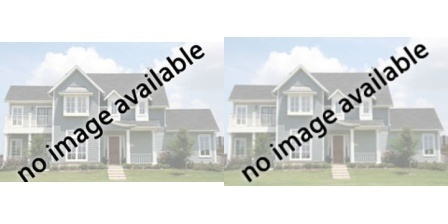
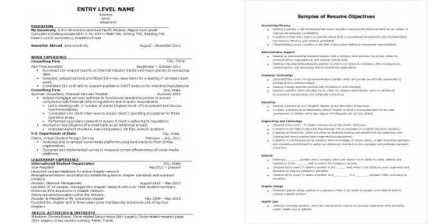

In [79]:
from IPython.display import HTML
fd.vis.component_gallery(external_df=comps, label_col='baby') 

# Wrap Up

Next, feel free to check out other tutorials -

+ ⚡ [**Quickstart**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/quick-dataset-analysis.ipynb): Learn how to install fastdup, load a dataset and analyze it for potential issues such as duplicates/near-duplicates, broken images, outliers, dark/bright/blurry images, and view visually similar image clusters. If you're new, start here!
+ 🧹 [**Clean Image Folder**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/cleaning-image-dataset.ipynb): Learn how to analyze and clean a folder of images from potential issues and export a list of problematic files for further action. If you have an unorganized folder of images, this is a good place to start.
+ 🖼 [**Analyze Image Classification Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-image-classification-dataset.ipynb): Learn how to load a labeled image classification dataset and analyze for potential issues. If you have labeled ImageNet-style folder structure, have a go!
+ 🎁 [**Analyze Object Detection Dataset**](https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-object-detection-dataset.ipynb): Learn how to load bounding box annotations for object detection and analyze for potential issues. If you have a COCO-style labeled object detection dataset, give this example a try. 


## VL Profiler
If you prefer a no-code platform to inspect and visualize your dataset, [**try our free cloud product VL Profiler**](https://app.visual-layer.com) - VL Profiler is our first no-code commercial product that lets you visualize and inspect your dataset in your browser. 

[Sign up](https://app.visual-layer.com) now, it's free.

[![image](https://raw.githubusercontent.com/visual-layer/fastdup/main/gallery/vl_profiler_promo.svg)](https://app.visual-layer.com)

As usual, feedback is welcome! 

Questions? Drop by our [Slack channel](https://visualdatabase.slack.com/join/shared_invite/zt-19jaydbjn-lNDEDkgvSI1QwbTXSY6dlA#/shared-invite/email) or open an issue on [GitHub](https://github.com/visual-layer/fastdup/issues).